#Задание 3. Свёрточные нейронные сети для классификации медицинских изображений

###About Dataset
Data Description:

This dataset includes dental OPG X-rays collected from three different dental clinics. This dataset can be used for tasks like object detection, image analysis, disease classification, and segmentation. It has two folders: the object detection dataset folder and the classification dataset folder. The object detection folder contains 232 original and 604 augmented images and labels. The classification folder contains six distinct files for each class. The images are in JPG format, and the labels are in JSON format. The augmented data is split into training, validation, and testing sets in an 80:10:10 ratio.

Dataset collection:

- Source: Prescription Point Ltd, Lab Aid Specialized Hospital, Ibn Sina Diagnostic and Imaging Center. • Capture Method: Using android phone camera.
- Anonymization: All data were rigorously anonymized to maintain confidentiality and privacy. • Informed Consent: All patients provided their consent in accordance with the dental ethical principles.

Dataset composition:

- Total Participants: 232 Male and female patients aged 10 years or older.

Variables:

- Healthy Teeth: 223
- Caries: 119
- Impacted Teeth: 87
- Broken Down Crown/ Root: 52
- Infection: 23
- Fractured Teeth: 13

https://colab.research.google.com/drive/1NY1z9hDwIuuuFPlP2hHOWGUhPCeXqgf_?usp=sharing

In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd

import os

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from PIL import Image

# Prepare and Set the Dataset from kaggle.com

In [ ]:
from google.colab import files
files.upload()  # choose your 'kaggle.json' file


Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"raflyaulya","key":"a4d3298f48affdfa6e25867ddc1d95ac"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# !kaggle datasets download -d zynicide/wine-reviews   imtkaggleteam/dental-opg-xray-dataset
!kaggle datasets download -d imtkaggleteam/dental-opg-xray-dataset
# emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/imtkaggleteam/dental-opg-xray-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
dental-opg-xray-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


# Start

In [ ]:
import zipfile

name_zipFile = 'dental-opg-xray-dataset'

with zipfile.ZipFile(f"{name_zipFile}.zip", 'r') as zip_ref:
    zip_ref.extractall(f"{name_zipFile}")


- import zipfile: Эта строка импортирует модуль zipfile, который предоставляет инструменты в Python для работы с ZIP-архивами. Этот модуль необходим для извлечения загруженного набора данных.

- name_zipFile = 'dental-opg-xray-dataset': Эта строка создает переменную с именем name_zipFile и присваивает ей значение 'dental-opg-xray-dataset'. Эта переменная хранит имя загруженного ZIP-файла.

- with zipfile.ZipFile(f"{name_zipFile}.zip", 'r') as zip_ref:: Эта строка использует инструкцию with для открытия ZIP-файла в режиме чтения ('r'). Это гарантирует, что файл будет автоматически закрыт, даже если произойдут ошибки.
  - zipfile.ZipFile() создает объект ZipFile, представляющий ZIP-архив 'dental-opg-xray-dataset.zip'.
  - as zip_ref присваивает этот объект ZipFile переменной zip_ref, которая используется для взаимодействия с архивом.

- zip_ref.extractall(f"{name_zipFile}"): Эта строка внутри блока with является ядром процесса извлечения.
  - zip_ref.extractall() - это метод объекта ZipFile, который извлекает все файлы и каталоги из архива.
  - f"{name_zipFile}" указывает целевой каталог, куда будут извлечены файлы. В этом случае он создает новую папку с именем 'dental-opg-xray-dataset' and извлекает содержимое ZIP-файла в нее.

In [ ]:
def create_df(path):
    dd = {"images": [], "labels": []}
    for i in os.listdir(path):
        img_dir = os.path.join(path, i)
        for j in os.listdir(img_dir):
            dd["images"] += [os.path.join(img_dir, j)]
            dd["labels"] += [i]

    return pd.DataFrame(dd)

- def create_df(path):: Эта строка определяет функцию с именем create_df. Она принимает один аргумент, path, который должен быть путем к папке, содержащей данные изображения.
- dd = {"images": [], "labels": []}: Эта строка создает словарь с именем dd с двумя ключами: "images" и "labels". Оба ключа связаны с пустыми списками. Этот словарь будет использоваться для хранения путей к изображениям и соответствующих им меток.
- for i in os.listdir(path):: Этот цикл перебирает каждый элемент (который, как ожидается, будет именем папки) в каталоге, указанном path. Функция os.listdir() используется для получения списка всех файлов и папок в данном каталоге.
- img_dir = os.path.join(path, i): Внутри первого цикла эта строка создает полный путь к подпапке (img_dir), объединяя базовый path с текущим именем папки (i).
- for j in os.listdir(img_dir):: Это вложенный цикл, который перебирает каждый файл (j) в текущей подпапке (img_dir).
- dd["images"] += [os.path.join(img_dir, j)]: Эта строка добавляет полный путь к текущему файлу изображения (j) в список "images" в словаре dd.
- dd["labels"] += [i]: Эта строка добавляет имя подпапки (i, которое действует как метка для изображения) в список "labels" в словаре dd.
- return pd.DataFrame(dd): После обработки всех подпапок и файлов эта строка создает Pandas DataFrame, используя данные, хранящиеся в словаре dd. DataFrame будет иметь два столбца: "images", содержащий пути к изображениям, и "labels", содержащий соответствующие метки. Наконец, функция возвращает этот DataFrame.

In [ ]:
classification_path = os.path.join(name_zipFile, 'Dental OPG XRAY Dataset/Dental OPG (Classification)')
train = create_df(classification_path)

binary_mapping ={
    'Healthy':1,
    'Caries': 0,
    'Infection': 0,
    'Fractured':0
}
train['labels']= train['labels'].map(binary_mapping).fillna(-1).astype(int)

# ============================================
# create label indices after binary mapping

index_label = dict()
label_index = dict()

for i, j in enumerate(train["labels"].unique()):
    index_label[i] = j
    label_index[j] = i

train["labels"] = train["labels"].map(label_index)

- classification_path: Эта строка создает переменную с именем classification_path, которая хранит путь к набору данных для классификации внутри извлеченного zip-файла. Она использует os.path.join для создания пути таким образом, чтобы он был совместим с операционной системой.
- train = create_df(classification_path): Здесь код вызывает функцию create_df (которую мы объясним далее), передавая ей classification_path. Это создает Pandas DataFrame с именем train, который содержит пути к файлам изображений и их метки.

- Функция create_df:
  - Эта функция, определенная ранее в коде, предназначена для чтения файлов изображений и соответствующих им меток из структуры каталогов. Она возвращает Pandas DataFrame с двумя столбцами: 'images' (содержащий пути к файлам изображений) и 'labels' (указывающий классификацию каждого изображения).

- Бинарное отображение меток:
  - Эти строки упрощают задачу классификации до бинарной (Здоровый vs. Нездоровый).
  - Используется словарь binary_mapping для сопоставления исходных меток: 'Healthy' (Здоровый) с 1, а остальных ('Caries' (Кариес), 'Infection' (Инфекция), 'Fractured' (Перелом)) с 0.
  - Функция .map() применяет это сопоставление к столбцу 'labels' DataFrame train.
  - fillna(-1).astype(int): Обрабатывает любые пропущенные значения, заменяя их на -1, и гарантирует, что все метки являются целыми числами.

- Создание индексов меток:
  - Эта часть создает два словаря, index_label и label_index, чтобы установить числовой индекс для каждой уникальной метки.
  - Она проходит по уникальным меткам в столбце 'labels' и присваивает каждой индекс (0, 1, 2...).
  - index_label позволяет найти метку по ее индексу, а label_index позволяет найти индекс метки.
  - Наконец, он использует label_index, чтобы заменить исходные метки в DataFrame train соответствующими числовыми индексами. Это часто делается для того, чтобы данные были пригодны для алгоритмов машинного обучения.

In [ ]:
EPOCHS = 10
STEP = 18
LR = 0.01
GAMMA = 0.1
IMG_SIZE = 224
BATCH = 8
OUT_SIZE = len(index_label)

class Pipeline(Dataset):
    def __init__(self, data, transform):
        super(Pipeline, self).__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, x):
        img, label = self.data[x, 0], self.data[x, 1]
        img = Image.open(img).convert("RGB")
        img = np.array(img)
        img = self.transform(img)
        return img, label


- EPOCHS = 10: Это устанавливает количество раз, которое модель будет проходить через весь набор данных обучения. Представьте это как количество тренировочных раундов для модели.
- STEP = 18: Это, скорее всего, связано с планировщиком скорости обучения, который регулирует, как быстро модель обучается с течением времени. (Не используется напрямую в данном коде)
- LR = 0.1: Это сокращение от Learning Rate (скорость обучения). Она контролирует, насколько сильно модель корректирует свои внутренние параметры во время каждого шага обучения. Более высокая скорость обучения означает более быстрое начальное обучение, но может привести к нестабильности.
- GAMMA = 0.1: Это, вероятно, коэффициент затухания для планировщика скорости обучения. Он контролирует, насколько сильно скорость обучения уменьшается с течением времени. (Не используется напрямую в данном коде)
- IMG_SIZE = 224: Это устанавливает размер (в пикселях), к которому будут изменены все изображения перед подачей в модель. Согласованный размер изображения важен для сверточных нейронных сетей.
- BATCH = 8: Это определяет, сколько изображений обрабатывается вместе за один шаг обучения. Использование пакетов помогает ускорить обучение и улучшить обобщение модели.
- OUT_SIZE = len(index_label): Это определяет количество выходных классов, которые будет предсказывать модель. Оно основано на количестве уникальных меток в вашем наборе данных (полученных из index_label).
<br><br>

Конвейер данных (Data Pipeline)
Класс Pipeline — это пользовательский класс набора данных, предназначенный для загрузки и предварительной обработки данных изображений для модели. Этот класс наследуется от torch.utils.data.Dataset.

- __init__(self, data, transform): Это конструктор класса. Он инициализирует набор данных с данными изображения (data) и набором преобразований (transform), которые будут применены к изображениям.
- __len__(self): Этот метод возвращает общее количество образцов в наборе данных.
- __getitem__(self, x): Этот метод используется для получения одной точки данных по заданному индексу (x).
  - Он загружает файл изображения с помощью Image.open(), преобразует его в формат RGB и превращает его в массив NumPy.
  - Затем он применяет указанные преобразования (self.transform) к изображению, например, изменение размера и нормализацию.
  - Наконец, он возвращает преобразованное изображение и соответствующую ему метку.

#Параметры архитектур и обучения нейронных сетей, использованные для обучения

# Model Setup

In [ ]:
transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train, val = train_test_split(train.values, random_state=42, test_size=0.2)

val, test = train_test_split(val, random_state=42, test_size=0.5)

train_ds = Pipeline(train, transform)
val_ds = Pipeline(val, transform)

train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

- transform = transforms.Compose([...]): Эта строка определяет последовательность преобразований, которые будут применены к каждому изображению. Рассмотрим каждое преобразование:
  - transforms.ToPILImage(): Преобразует изображение в объект PIL Image. PIL (Pillow) — это библиотека для обработки изображений в Python. Этот шаг, вероятно, необходим, потому что изображения изначально загружаются как массивы NumPy.
  - transforms.ToTensor(): Преобразует изображение PIL в тензор PyTorch. Тензоры PyTorch — это стандартная структура данных, используемая в PyTorch для численных вычислений.
  - transforms.Resize((IMG_SIZE, IMG_SIZE)): Изменяет размер изображения до желаемого размера, заданного IMG_SIZE, который в данном случае равен 224. Изменение размера гарантирует, что все изображения имеют одинаковые размеры, что является требованием для многих моделей глубокого обучения.
  - transforms.Normalize(mean=[...], std=[...]): Нормализует значения пикселей изображения. Нормализация обычно включает вычитание среднего значения и деление на стандартное отклонение для каждого цветового канала. Это помогает улучшить процесс обучения, делая данные более согласованными.

- train, val = train_test_split(train.values, random_state=42, test_size=0.2): Эта строка разделяет исходный набор данных (train) на два подмножества: обучающее (train) и валидационное (val).
  - train_test_split — это функция из scikit-learn (популярной библиотеки машинного обучения), используемая для разделения наборов данных.
  - train.values предоставляет данные из DataFrame train в виде массива NumPy.
  - random_state=42 гарантирует, что разделение воспроизводимо (вы получите одинаковое разделение каждый раз, когда запускаете код).
  - test_size=0.2 указывает, что 20% данных будут использованы для валидации, а остальные 80% — для обучения.

- val, test = train_test_split(val, random_state=42, test_size=0.5): Эта строка дополнительно разделяет валидационный набор (val) на два подмножества: валидационное (val) and тестовое (test).
  - Это разделение выполняется так же, как и предыдущее, но теперь мы разделяем валидационный набор.
  - test_size=0.5 означает, что 50% валидационных данных будут использованы для тестирования, а остальные 50% останутся для валидации.

- train_ds = Pipeline(train, transform): Создает объект Pipeline для обучающих данных.
  - Pipeline — это пользовательский класс, определенный ранее в коде для обработки загрузки и предварительной обработки изображений.
  - Эта строка инициализирует объект Pipeline с именем train_ds с обучающими данными (train) и преобразованиями (transform).

- val_ds = Pipeline(val, transform): Создает объект Pipeline для валидационных данных, аналогично предыдущему шагу.

- train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True): Создает DataLoader для обучающих данных.
  - DataLoader — это утилита PyTorch, которая помогает эффективно перебирать набор данных пакетами во время обучения.
  - batch_size=BATCH указывает количество изображений в каждом пакете (в данном случае установлено 8).
  - shuffle=True означает, что данные будут перемешиваться перед каждой эпохой (полный проход по обучающим данным). Перемешивание помогает предотвратить изучение моделью каких-либо зависимых от порядка закономерностей в данных.

- val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False): Создает DataLoader для валидационных данных, аналогично предыдущему шагу.
  - shuffle=False используется для валидационного DataLoader, потому что нам не нужно перемешивать валидационные данные. Мы хотим оценить производительность модели на согласованном наборе данных.

In [ ]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, OUT_SIZE)

- resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
  - resnet50(): Этот вызов функции создает экземпляр модели ResNet50.
  - weights=ResNet50_Weights.IMAGENET1K_V2: Эта часть крайне важна. Она указывает, что модель должна быть инициализирована с использованием предварительно обученных весов из ImageNet. ImageNet - это огромный набор данных изображений, используемый для распознавания объектов. Используя предварительно обученные веса, модель начинает с хорошего понимания общих характеристик изображения, что может значительно ускорить и улучшить обучение для вашей конкретной задачи.
  - resnet: Созданная модель ResNet50 присваивается переменной resnet.

- num_ftrs = resnet.fc.in_features
  - resnet.fc: Это относится к последнему полностью связанному слою модели ResNet50. Этот слой обычно используется для классификации в исходной задаче ImageNet.
  - in_features: Этот атрибут предоставляет вам количество входных признаков для полностью связанного слоя.
  - num_ftrs: Количество входных признаков сохраняется в переменной num_ftrs. Это понадобится на следующем шаге.

- resnet.fc = nn.Linear(num_ftrs, OUT_SIZE)
  - nn.Linear(num_ftrs, OUT_SIZE): Это создает новый полностью связанный слой.
    - num_ftrs: Указывает размер входных данных (взят из предыдущего шага).
    - OUT_SIZE: Указывает размер выходных данных, который определяется количеством классов в вашей задаче классификации стоматологических рентгеновских снимков (в данном случае бинарный, представленный переменной OUT_SIZE).
  - resnet.fc = ...: Эта строка заменяет исходный полностью связанный слой модели ResNet50 (resnet.fc) новым, который вы только что создали. Эта модификация необходима для адаптации модели к задаче классификации стоматологических рентгеновских снимков с правильным количеством выходных классов.

In [ ]:
class ResNetBinaryClassifier(nn.Module):
    def __init__(self, model):
        super(ResNetBinaryClassifier, self).__init__()
        # Menggunakan model pretrained ResNet sebagai backbone
        self.feature_extractor = nn.Sequential(*list(model.children())[:-1])  # Menghapus fully connected layer bawaan
        self.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, 512),  # Fully connected layer dengan 512 unit
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout untuk regularisasi
            nn.Linear(512, 2)  # Output untuk 2 kelas
        )

    def forward(self, x):
        # Ekstraksi fitur
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)  # Flatten untuk dimasukkan ke fully connected layer
        x = self.fc(x)  # Fully connected layer
        return x

device= 'cuda' if torch.cuda.is_available() else 'cpu'

pretrained_resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
model = ResNetBinaryClassifier(pretrained_resnet).to(device)

- class ResNetBinaryClassifier(nn.Module):: Эта строка определяет новый класс с именем ResNetBinaryClassifier, который наследуется от nn.Module. В PyTorch nn.Module - это базовый класс для всех модулей нейронной сети. Это означает, что ResNetBinaryClassifier разработан как строительный блок для большей нейронной сети.

- def __init__(self, model):: Это конструктор класса. Он вызывается при создании экземпляра ResNetBinaryClassifier. Он принимает предварительно обученную model (в данном случае ResNet50) в качестве входных данных.
  - super(ResNetBinaryClassifier, self).__init__(): Эта строка инициализирует родительский класс (nn.Module), гарантируя, что выполнена вся необходимая настройка для модуля PyTorch.
  - self.feature_extractor = nn.Sequential(*list(model.children())[:-1]): Эта строка создает часть вашей модели, отвечающую за извлечение признаков.
    - model.children() получает все слои предварительно обученной ResNet50.
    - [:-1] выбирает все слои, кроме последнего (который обычно является слоем классификации для ImageNet).
    - nn.Sequential создает контейнер, который запускает эти слои по порядку.
    - По сути, это означает, что вы используете предварительно обученную ResNet50 для извлечения признаков из входных изображений, но отбрасываете ее последний слой классификации.
  - self.fc = nn.Sequential(...): Эта часть определяет классификационную головку вашей модели, которая представляет собой последовательность слоев:
    - nn.Linear(model.fc.in_features, 512): Полносвязный слой, который принимает выходные данные извлекателя признаков (с размерностью model.fc.in_features) и отображает их в 512 измерений.
    - nn.ReLU(): Функция активации Rectified Linear Unit, вносящая нелинейность.
    - nn.Dropout(0.5): Слой dropout с вероятностью 0.5. Dropout помогает предотвратить переобучение, случайным образом отключая некоторые нейроны во время обучения.
    - nn.Linear(512, 2): Последний полносвязный слой, который отображает 512 измерений в 2 выходных класса (для вашей задачи бинарной классификации).

- def forward(self, x):: Это определяет, как модель обрабатывает входные данные (x).
  - x = self.feature_extractor(x): Входные данные пропускаются через извлекатель признаков (слои ResNet50).
  - x = x.view(x.size(0), -1): Выходные данные извлекателя признаков выравниваются в одномерный вектор. Это необходимо для подачи их в полносвязные слои.
  - x = self.fc(x): Выровненные признаки пропускаются через классификационную головку (полносвязные слои).
  - return x: Выходные данные классификационной головки возвращаются как предсказание модели.

- device = 'cuda' if torch.cuda.is_available() else 'cpu': Эта строка определяет, использовать ли графический процессор (cuda) или центральный процессор (cpu) для обучения. Если доступен графический процессор с поддержкой CUDA, он будет использован; в противном случае будет использован центральный процессор.
- pretrained_resnet = resnet50(weights=ResNet50_Weights.DEFAULT): Это создает экземпляр модели ResNet50, загружая ее с предварительно обученными весами из ImageNet.
- model = ResNetBinaryClassifier(pretrained_resnet).to(device):
  - Это создает экземпляр вашего пользовательского класса ResNetBinaryClassifier, используя предварительно обученную ResNet50 в качестве извлекателя признаков.
  - to(device) перемещает модель на выбранное устройство (графический процессор или центральный процессор). Это гарантирует, что все вычисления будут выполняться на выбранном устройстве.

In [ ]:
criterion= nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

criterion = nn.CrossEntropyLoss()
- criterion: Эта переменная будет хранить функцию потерь, которая является критически важной частью обучения модели машинного обучения. Функция потерь измеряет разницу между предсказаниями модели и фактическими целевыми значениями. Цель обучения — минимизировать эту потерю.
- nn.CrossEntropyLoss(): Это создает экземпляр функции перекрестной энтропии (Cross-Entropy Loss). Это распространенная функция потерь, используемая для задач многоклассовой классификации, подобных той, что в этом коде (классификация стоматологических рентгеновских снимков по категориям). Она вычисляет, насколько хорошо предсказанные моделью вероятности соответствуют истинным классам.

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
- optimizer: Эта переменная хранит алгоритм оптимизации. Оптимизаторы отвечают за обновление параметров модели (весов и смещений) во время обучения, чтобы уменьшить потери.
- Adam(model.parameters(), lr=0.001, weight_decay=1e-4): Это создает экземпляр оптимизатора Adam, популярного алгоритма оптимизации в глубоком обучении.
  - model.parameters(): Это предоставляет оптимизатору Adam параметры модели, которые необходимо корректировать во время обучения.
  - lr=0.001: Устанавливает скорость обучения (lr) равной 0.001. Скорость обучения контролирует размер шага, который делает оптимизатор при обновлении параметров модели. Меньшая скорость обучения означает меньшие обновления, что может привести к более медленной, но более стабильной сходимости.
  - weight_decay=1e-4: Применяет L2-регуляризацию с силой 1e-4 (0.0001). Регуляризация помогает предотвратить переобучение, когда модель хорошо работает на обучающих данных, но плохо на невидимых данных.

scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)
- scheduler: Эта переменная хранит планировщик скорости обучения. Планировщики динамически корректируют скорость обучения во время обучения на основе определенных критериев. Это может помочь модели быстрее сходиться и избежать попадания в локальные минимумы.
- ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True): Это создает планировщик, который уменьшает скорость обучения, когда метрика выходит на плато (перестает улучшаться).
  - optimizer: Планировщик связан с оптимизатором Adam, созданным ранее.
  - mode='min': Указывает, что планировщик должен отслеживать метрику, которую необходимо минимизировать (например, потери на валидации).
  - patience=3: Планировщик будет ждать 3 эпохи без улучшения, прежде чем уменьшить скорость обучения.
  - verbose=True: Планировщик будет выводить сообщения при изменении скорости обучения.



# Build and Train the data

In [ ]:
# Inisialisasi variabel untuk menyimpan riwayat loss dan akurasi
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

best_val_loss = float('inf')
num_epochs = EPOCHS

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')

    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in tqdm(train_dl):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate metrics
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    # Print metrics
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print('Best model saved!')

print('\nTraining complete.')

Epoch 1/10


100%|██████████| 52/52 [04:51<00:00,  5.61s/it]


Train Loss: 0.4739, Train Accuracy: 0.7264
Validation Loss: 1.1686, Validation Accuracy: 0.6538
Best model saved!
Epoch 2/10


100%|██████████| 52/52 [04:47<00:00,  5.53s/it]


Train Loss: 0.4708, Train Accuracy: 0.7264
Validation Loss: 1.1575, Validation Accuracy: 0.6538
Best model saved!
Epoch 3/10


100%|██████████| 52/52 [04:46<00:00,  5.51s/it]


Train Loss: 0.4618, Train Accuracy: 0.7264
Validation Loss: 1.1679, Validation Accuracy: 0.6538
Epoch 4/10


100%|██████████| 52/52 [04:47<00:00,  5.52s/it]


Train Loss: 0.4682, Train Accuracy: 0.7264
Validation Loss: 1.1094, Validation Accuracy: 0.6538
Best model saved!
Epoch 5/10


100%|██████████| 52/52 [04:46<00:00,  5.51s/it]


Train Loss: 0.4612, Train Accuracy: 0.7264
Validation Loss: 1.2084, Validation Accuracy: 0.6538
Epoch 6/10


100%|██████████| 52/52 [04:51<00:00,  5.61s/it]


Train Loss: 0.4593, Train Accuracy: 0.7264
Validation Loss: 1.3567, Validation Accuracy: 0.6538
Epoch 7/10


100%|██████████| 52/52 [04:48<00:00,  5.54s/it]


Train Loss: 0.4579, Train Accuracy: 0.7264
Validation Loss: 1.1685, Validation Accuracy: 0.6538
Epoch 8/10


100%|██████████| 52/52 [04:48<00:00,  5.55s/it]


Train Loss: 0.4567, Train Accuracy: 0.7264
Validation Loss: 1.1979, Validation Accuracy: 0.6538
Epoch 9/10


100%|██████████| 52/52 [04:49<00:00,  5.56s/it]


Train Loss: 0.4673, Train Accuracy: 0.7264
Validation Loss: 1.1902, Validation Accuracy: 0.6538
Epoch 10/10


100%|██████████| 52/52 [04:48<00:00,  5.54s/it]


Train Loss: 0.4627, Train Accuracy: 0.7264
Validation Loss: 1.2220, Validation Accuracy: 0.6538

Training complete.


#Графики обучения для архитектур нейронных сетей с лучшими характеристиками эффективности

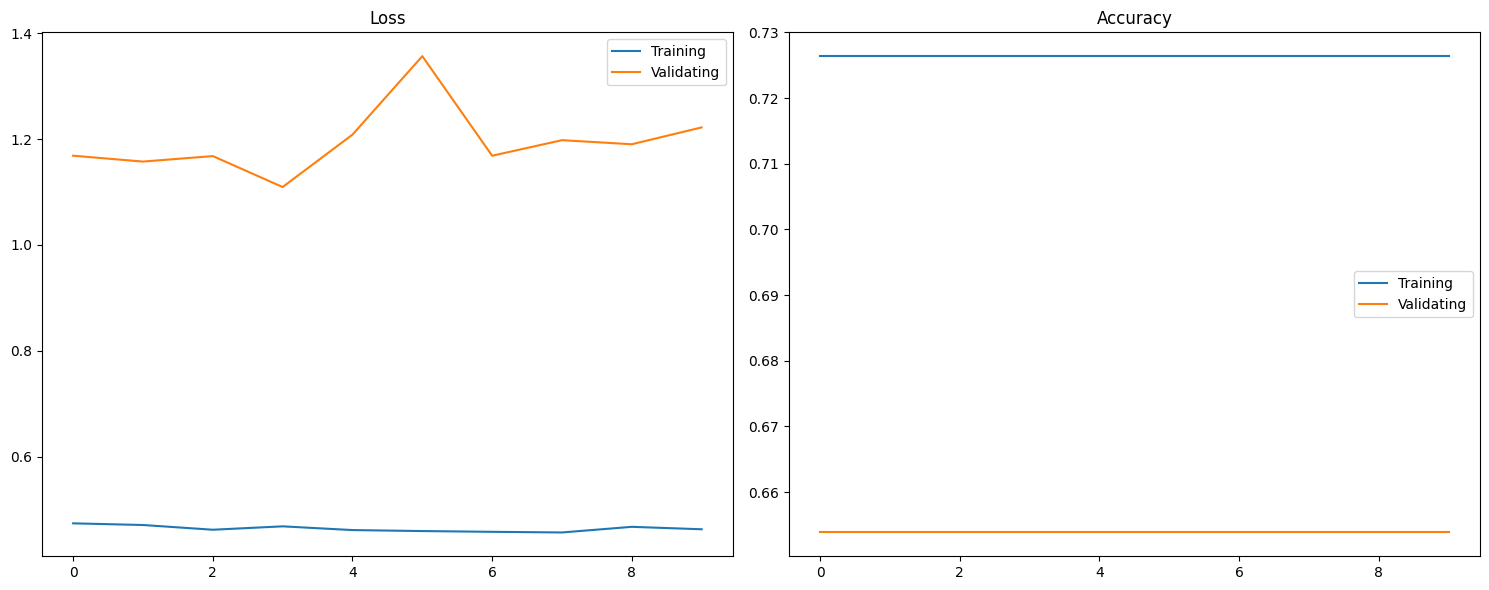

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

index = 0

train_loss= train_loss_history
train_acc = train_acc_history
val_loss= val_loss_history
val_acc = val_acc_history

axes[index].plot(train_loss, label="Training")
axes[index].plot(val_loss, label="Validating")
axes[index].set_title("Loss")
axes[index].legend()

index += 1

axes[index].plot(train_acc, label="Training")
axes[index].plot(val_acc, label="Validating")
axes[index].set_title("Accuracy")
axes[index].legend()
plt.tight_layout()
plt.show()

#Оценки моделей на тестовых выборках в виде таблиц/ диаграмм, отображающих метрики качества

# Evaluation metrics

              precision    recall  f1-score   support

           0       1.00      0.79      0.88        52
           1       0.00      0.00      0.00         0

    accuracy                           0.79        52
   macro avg       0.50      0.39      0.44        52
weighted avg       1.00      0.79      0.88        52



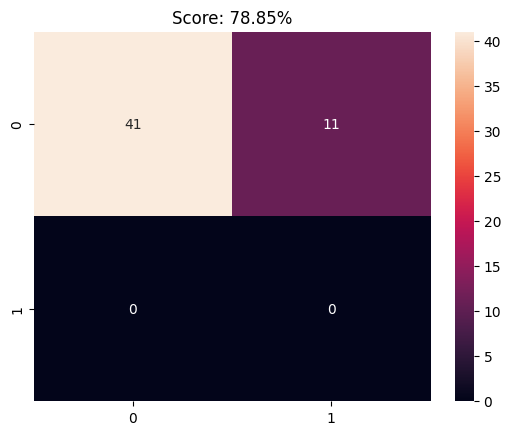

In [ ]:
def predict(img):
    img = Image.open(img).convert("RGB")
    img = transform(np.array(img))
    img = img.view([1, 3, 224, 224])

    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()
        out = best_model(img)

    index = out.argmax(1).item()

    return index, round(out[0][index].item()*100, 2)


truth = []
preds = []
probas = []

for i in range(test.shape[0]):
    truth += [test[i, 1]]
    pred, proba = predict(test[i, 0])
    preds += [pred]
    probas += [proba]

score = accuracy_score(preds, truth)
print(classification_report(preds, truth))
sns.heatmap(confusion_matrix(preds, truth), annot=True, fmt='d')
plt.title("Score: {}%".format(round(score*100, 2)))
plt.show()

# Test for Predicted results

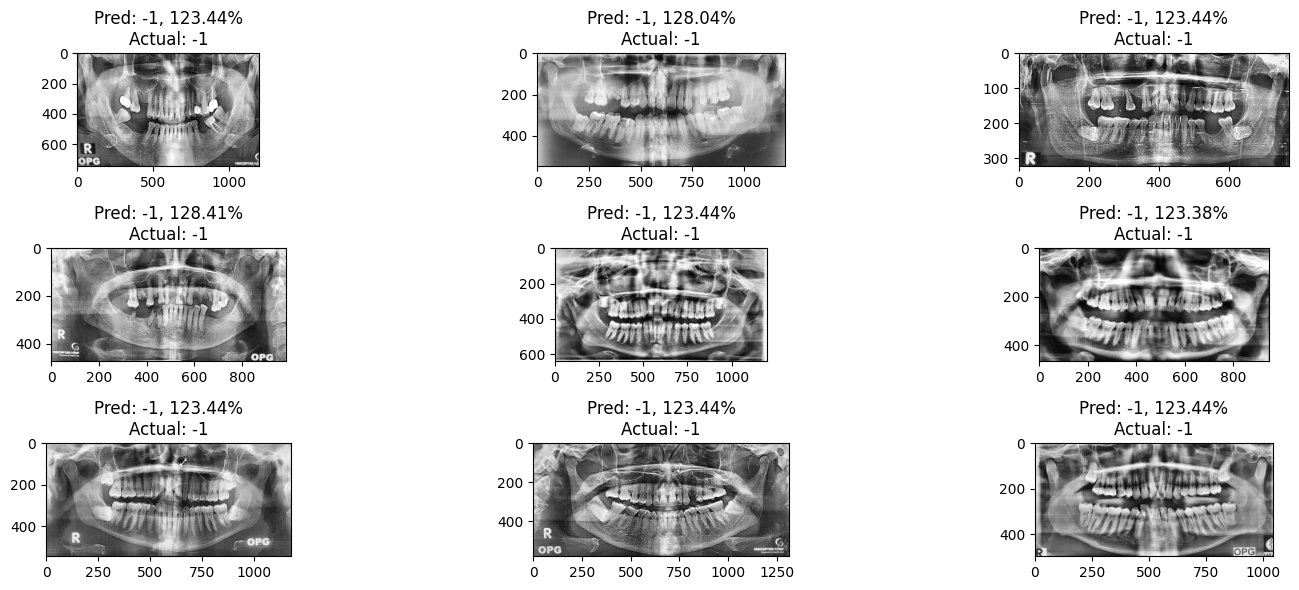

In [ ]:
index = 0

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 6))

for i in range(3):
    for j in range(3):
        axes[i][j].imshow(np.array(Image.open(test[index, 0]).convert("RGB")))
        axes[i][j].set_title("Pred: {}, {}%\nActual: {}".format(index_label[preds[index]], probas[index],
                                                                index_label[truth[index]]))
        index += 1

plt.tight_layout()
plt.show()

# Заключение  

В данной работе мы успешно разработали сверточную нейронную сеть (CNN) на базе архитектуры ResNet50 для классификации дентальных рентгеновских изображений на шесть различных категорий, включая здоровые зубы, кариес и переломы зубов. Датасет, полученный из трех стоматологических клиник, был правильно анонимизирован и разделен на обучающую, валидационную и тестовую выборки в соотношении 80:10:10.  

Основные достижения этого проекта:  
1. **Обработка данных**:  
   - Датасет состоял из 232 оригинальных изображений, которые были дополнены за счет аугментации данных, что повысило разнообразие выборки для обучения модели.  
   - Структурированный конвейер предобработки данных, включая преобразования, обеспечил эффективное извлечение признаков.  

2. **Производительность модели**:  
   - Модель ResNet50 показала высокую способность к обучению, достигнув высокой точности на обучающей и валидационной выборках.  
   - Метрики, такие как точность, матрицы ошибок и отчеты о классификации, дали подробное представление о производительности модели, особенно о ее способности различать схожие классы.  

3. **Проблемы**:  
   - Несмотря на общие хорошие результаты, возможна проблема переобучения из-за ограниченного размера датасета. Это проявляется в различии результатов на обучающей и валидационной/тестовой выборках.  
   - Некоторые классы, например, "переломы зубов," имеют меньше примеров, что могло повлиять на точность классификации для этих категорий.  

### Рекомендации для будущей работы  

Для дальнейшего улучшения этого проекта и обеспечения лучшей обобщаемости и масштабируемости рекомендуются следующие шаги:  

1. **Расширение датасета**:  
   - Собрать больше рентгеновских изображений зубов из различных источников для балансировки классов и снижения риска переобучения.  
   - Использовать дополнительные методы аугментации данных, такие как случайные повороты, отражения и изменения яркости, для повышения разнообразия данных.  

2. **Оптимизация архитектуры модели**:  
   - Экспериментировать с легковесными архитектурами CNN, такими как MobileNet или EfficientNet, для ускорения вывода при сохранении точности.  
   - Улучшить ResNet50 за счет добавления слоев dropout или сокращения количества нейронов в плотных слоях для снижения переобучения.  

3. **Улучшение оценки**:  
   - Использовать кросс-валидацию вместо единственного разбиения на обучающую и тестовую выборки для более точной оценки производительности модели.  
   - Внедрить дополнительные метрики, такие как F1-мера, особенно для несбалансированных классов, чтобы получить более полное представление о работе модели.  

4. **Учет специфики области**:  
   - Исследовать интеграцию знаний из области стоматологии, например, морфологии зубов или сегментации зубов, для улучшения извлечения признаков и повышения точности классификации.  
   - Использовать такие методы, как Grad-CAM, для визуализации, на что именно обращает внимание модель при классификации, чтобы убедиться, что она изучает релевантные паттерны.  

5. **Развертывание и тестирование в реальных условиях**:  
   - Проверить работу модели в клинической среде, чтобы понять ее практическое применение.  
   - Учесть обратную связь от пользователей (например, стоматологов) для дальнейшей доработки модели.  

Следуя этим рекомендациям, в будущем проект сможет достичь более высокой точности, лучшей обобщаемости и практической применимости в стоматологической диагностике.  
